In [4]:
import matplotlib.pyplot as plt
# import numpy as np
import pandas as pd
# import seaborn as sns
import shap
# from mordred import Calculator, descriptors
# from mordred.error import Missing
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

In [5]:
taste_df = pd.read_csv("../data/ChemTastes_nonpeptides.csv")
# calc = Calculator(descriptors)

In [6]:
mols = [Chem.MolFromSmiles(smi) for smi in taste_df["canonical SMILES"]]

In [7]:
# descriptor_df = calc.pandas(mols)
# df = descriptor_df.fill_missing()

In [8]:
descs_df = pd.DataFrame([Descriptors.CalcMolDescriptors(mol) for mol in mols])

In [9]:
# concat descriptors and molecule SMILES
taste_descs_df = pd.concat([taste_df, descs_df], axis=1)

In [10]:
# taste_descs_df.to_csv("../data/ChemTastes_rdDescs_nonpeptides.csv")

In [11]:
# with open("missing.txt", "w") as f:
#     f.write(descs_df.isna().sum().to_string())

In [12]:
selector = VarianceThreshold(threshold=0.01)
filtered = selector.fit_transform(descs_df)
retained_descs = descs_df.columns[selector.get_support()]
vt_df = pd.DataFrame(filtered, columns=retained_descs)

In [13]:
vt_df.shape

(3071, 188)

In [14]:
# with open("missing.txt", "w") as f:
#     f.write(feature_train.to_string())

In [15]:
# corr_matrix = df_filtered.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
# to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]  # Drop if r > 0.85
# df_final = df_filtered.drop(to_drop, axis=1)

In [16]:
labels = taste_df["Class taste"].map(lambda x: "Bitterness"
                                     if x == "Bitterness" else "Non-bitterness")

In [17]:
feature_train, feature_test, label_train, label_test = train_test_split(
    vt_df, labels, test_size=0.2, random_state=527
)

In [18]:
rf_clf = RandomForestClassifier(n_estimators=250)
rf_clf.fit(feature_train, label_train)

RandomForestClassifier(n_estimators=250)

In [19]:
pred = rf_clf.predict(feature_test)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(label_test, pred, digits=3))

                precision    recall  f1-score   support

    Bitterness      0.895     0.825     0.858       268
Non-bitterness      0.872     0.925     0.898       347

      accuracy                          0.881       615
     macro avg      0.884     0.875     0.878       615
  weighted avg      0.882     0.881     0.881       615



In [21]:
importance_score = rf_clf.feature_importances_

feature_importance = pd.DataFrame({
    'Descriptor': feature_train.columns,
    'Importance': importance_score
}).sort_values('Importance', ascending=False)

# Feature Importance

In [22]:
feature_importance[:20]

,Descriptor,Importance
3,MinEStateIndex,0.026300
17,BCUT2D_MWHI,0.021952
11,MinPartialCharge,0.021015
58,PEOE_VSA8,0.019077
127,MolLogP,0.017169
100,VSA_EState8,0.017047
23,BCUT2D_MRHI,0.016559
12,MaxAbsPartialCharge,0.016380
24,BCUT2D_MRLOW,0.014981
4,qed,0.014538


In [23]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(feature_train)

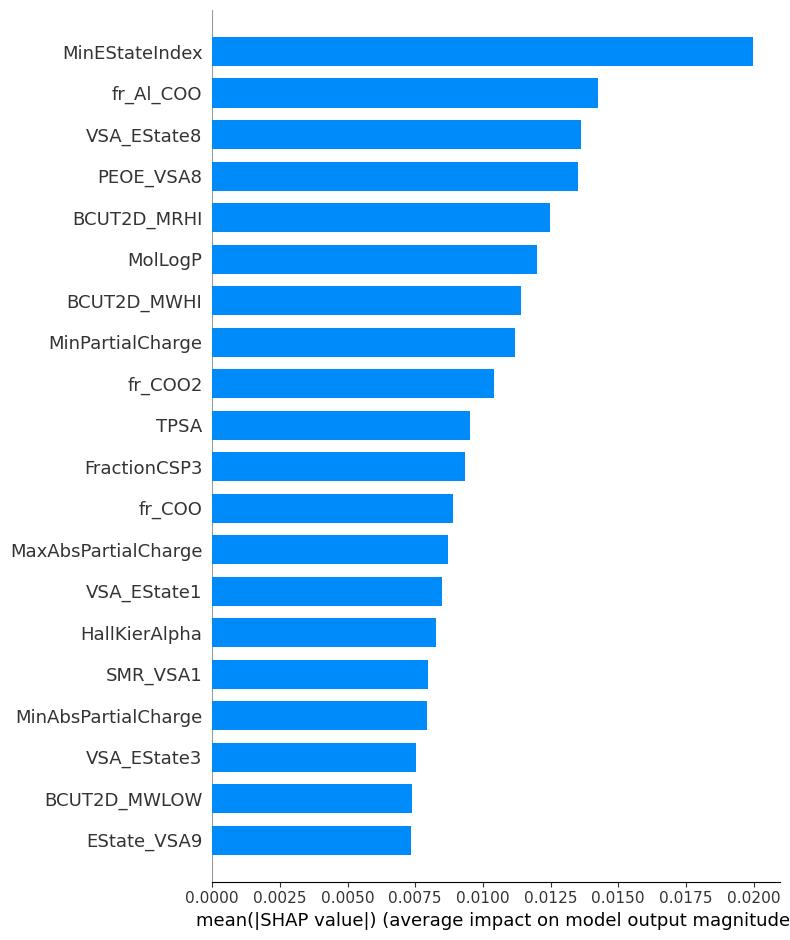

In [24]:
# shap.summary_plot(shap_values[:, :, 0])
shap.summary_plot(shap_values[:, :, 0], 
    plot_type="bar", 
    feature_names=feature_train.columns,
)

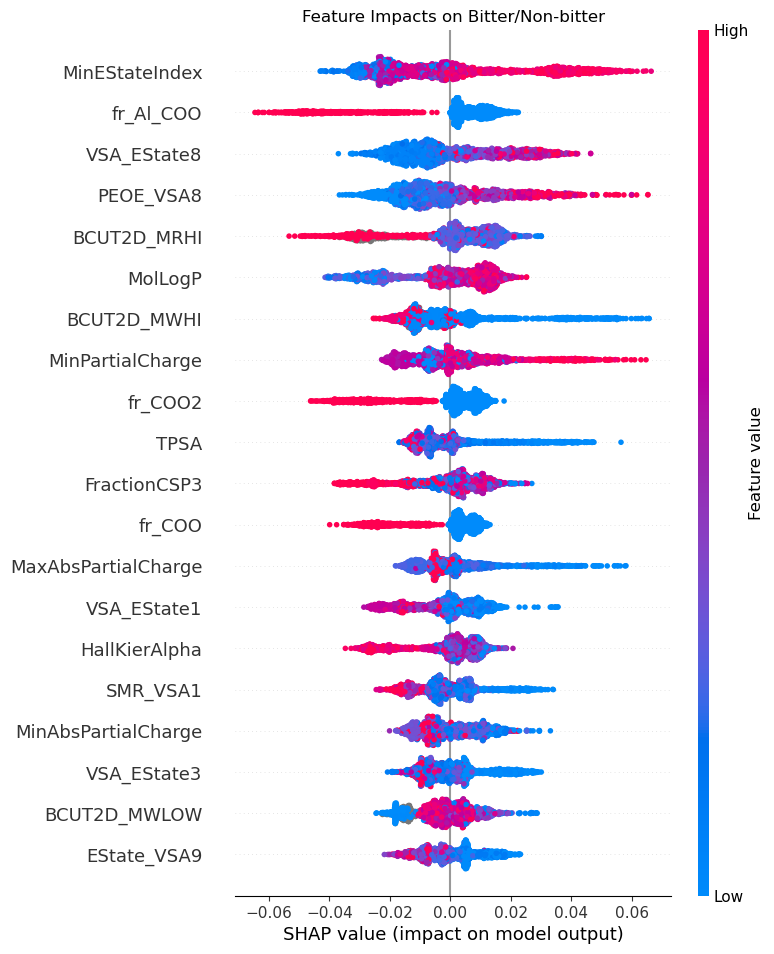

In [ ]:
shap_explainer = shap.TreeExplainer(rf_clf)
shap_values = shap_explainer.shap_values(feature_train)

shap.summary_plot(shap_values[:,:, 0], feature_train, show=False)
plt.title("Feature Impacts on Bitter/Non-bitter")
plt.show()

# Validation with external datasets

In [293]:
tas2r_df = pd.read_excel("../data/TAS2R.xlsx", header=1)

In [299]:
tas2r_smi = tas2r_df["Canonical SMILES"]
tas2r_labels = ["Bitterness"] * 247

In [246]:
def get_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None
    
    return Descriptors.CalcMolDescriptors(mol)

In [295]:
tas2r_descs = pd.DataFrame([get_descriptors(smi) for smi in tas2r_smi])

In [296]:
tas2r_descs = pd.DataFrame(tas2r_descs, columns=retained_descs)

In [298]:
pred_tas2r = rf_clf.predict(tas2r_descs)

In [300]:
print(classification_report(tas2r_labels, pred_tas2r, digits=3))

                precision    recall  f1-score   support

    Bitterness      1.000     0.883     0.938       247
Non-bitterness      0.000     0.000     0.000         0

      accuracy                          0.883       247
     macro avg      0.500     0.441     0.469       247
  weighted avg      1.000     0.883     0.938       247



/Users/Alex/Programs/miniconda3/envs/bioinfo/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Alex/Programs/miniconda3/envs/bioinfo/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Alex/Programs/miniconda3/envs/bioinfo/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap